# Домашнее задание №1

In [2]:
import csv
import re
import time
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import urllib.parse
from geopy.distance import geodesic
from shapely.geometry import Point
from sklearn.neighbors import BallTree

In [3]:
pd.set_option('display.max_columns', 500)

________________________________

## 1 Датасет из агрегатора Мир Квартир

Код сбора данных представлен в файле `mirkvartir.py`.

### 1. **Основной механизм работы**
- Используем POST-запросы к API `mirkvartir.ru` (`listingapi/ListingPageModel`)
- Собираем данные об аренде квартир в Санкт-Петербурге (регион ID 78)
- Работаем с пагинацией (постраничный сбор данных)

### 2. **Ключевые особенности**
- **Случайный порядок страниц**: страницы обрабатываются в перемешанном порядке (так удалось обойти блокировку)
- **Контроль задержек**:
  - Случайные паузы между запросами (2-5 сек)
  - Дополнительные паузы каждые 5 страниц (5-15 сек)
- **Обработка ошибок**: перехват сетевых ошибок и автоматическое продолжение работы

### 3. **Извлечение данных**
Для каждого объявления собирается:
- Основная информация (цена, описание)
- Геоданные (координаты, адрес)
- Инфраструктура (ближайшее метро)
- Информация о фото (количество, URL главного фото)
- Контактные данные (агентство)

### 4. **Сохранение результатов**
- Данные сохраняются в CSV через pandas
- Удаляются временные технические поля
- Сохраняется источник данных (`source: mirkvartir`)

### 5. **Защитные механизмы**
- User-Agent имитирует браузер
- HTTPS-запросы с корректными заголовками
- Таймаут запросов 15 секунд
- Сессионные соединения (не создает новое подключение для каждого запроса)

### 6. **Мониторинг процесса**
- Прогресс-бар (tqdm) для визуализации
- Подсчет обработанных страниц
- Логирование количества собранных объявлений

### Почему такой подход?
- API дает структурированные данные
- Случайный порядок страниц и задержки имитируют поведение человека

In [4]:
df_mk = pd.read_csv('C:/Users/popov/mirkvartir_random_pages_listings.csv')

In [5]:
df_mk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882 entries, 0 to 4881
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4882 non-null   int64  
 1   url             4882 non-null   object 
 2   title           4882 non-null   object 
 3   description     4881 non-null   object 
 4   price           4882 non-null   int64  
 5   latitude        4882 non-null   float64
 6   longitude       4882 non-null   float64
 7   metro_name      3563 non-null   object 
 8   address         4882 non-null   object 
 9   agency_name     4882 non-null   object 
 10  photos_count    4882 non-null   int64  
 11  photos          4882 non-null   object 
 12  main_photo_url  4882 non-null   object 
 13  update_time     4882 non-null   object 
 14  source          4882 non-null   object 
dtypes: float64(2), int64(3), object(10)
memory usage: 572.2+ KB


Описание данных:
1. `id` - уникальный идентификатор объявления (int64)
2. `url` - прямая ссылка на объявление (object)
3. `title` - заголовок объявления (object)
4. `description` - подробное описание (object, 1 пропуск)
5. `price` - стоимость аренды в рублях (int64)
6. `latitude` - координата широты (float64)
7. `longitude` - координата долготы (float64)
8. `metro_name` - ближайшая станция метро (object, 1274 пропуска)
9. `address` - полный адрес объекта (object)
10. `agency_name` - название агентства/собственника (object)
11. `photos_count` - количество фотографий (int64)
12. `photos` - массив с URL фотографий (object)
13. `main_photo_url` - ссылка на главное фото (object)
14. `update_time` - время последнего обновления (object)
15. `source` - источник данных (всегда "mirkvartir") (object)

Посмотрим на первые 5 строк собранных данных:

In [6]:
df_mk.head()

,id,url,title,description,price,latitude,longitude,metro_name,address,agency_name,photos_count,photos,main_photo_url,update_time,source
0,339229618,https://arenda.mirkvartir.ru/339229618/,"1-комн., 36.9 м², 19/25 этаж",Аренда на длительный срок 1-комнатной квартиры...,28000,60.071389,30.326360,Парнас,"Санкт-Петербург, п. Парголово, ул. Михаила Дуд...",«Главстрой Санкт-Петербург»,32,['https://f7.mirkvartir.me/custom/c2/c2328cb6-...,https://f7.mirkvartir.me/custom/c2/c2328cb6-51...,2025-04-07T23:51:17.523,mirkvartir
1,340658076,https://arenda.mirkvartir.ru/340658076/,"1-комн., 48 м², 8/16 этаж",Аренда на длительный срок однушки на 8 этаже 1...,42000,60.008495,30.347165,Площадь Мужества,"Санкт-Петербург, Большеохтинский пр-кт, 16к2",Агент,12,['https://f1.mirkvartir.me/custom/2d/2d5afdee-...,https://f1.mirkvartir.me/custom/2d/2d5afdee-44...,2025-04-05T01:10:33.403,mirkvartir
2,340192854,https://arenda.mirkvartir.ru/340192854/,"1-комн., 40 м², 7/25 этаж",Снять однокомнатную квартиру площадью 40 кв. м...,45000,59.987215,30.367947,Площадь Мужества,"Санкт-Петербург, Кушелевская дор., 3к1",Агент,19,['https://f6.mirkvartir.me/custom/e6/e67e2840-...,https://f6.mirkvartir.me/custom/e6/e67e2840-69...,2025-04-10T09:56:10.947,mirkvartir
3,340947392,https://arenda.mirkvartir.ru/340947392/,"2-комн., 67 м², 13/18 этаж",Сдается в длительную аренду двухкомнатная квар...,80000,59.934285,30.434006,Ладожская,"Санкт-Петербург, пер. Апраксин, 8стрА",GOLDEN HOME,24,['https://f0.mirkvartir.me/custom/fe/fe508308-...,https://f0.mirkvartir.me/custom/fe/fe508308-8f...,2025-04-10T02:07:47.17,mirkvartir
4,340947486,https://arenda.mirkvartir.ru/340947486/,"2-комн., 47 м², 6/9 этаж",Аренда на длительный срок двухкомнатной кварти...,45000,60.008950,30.344255,Площадь Мужества,"Санкт-Петербург, Раздельная ул., 3",GOLDEN HOME,19,['https://f9.mirkvartir.me/custom/b0/b0bb650e-...,https://f9.mirkvartir.me/custom/b0/b0bb650e-9b...,2025-04-10T02:07:50.477,mirkvartir


Приведем даты в корректный формат:

In [7]:
df_mk['update_time'] = pd.to_datetime(df_mk['update_time'], format='ISO8601')

df_mk['update_time'] = df_mk['update_time'].dt.tz_localize(None).dt.floor('s')

Извлечем из поля `title` информацию о количестве комнат, площади, этажах и рассчитаем стоимость квадратного метра:

In [8]:
df_mk['title'] = df_mk['title'].str.lower()

In [9]:
def extract_apartment_features(title):
    features = {
        'rooms': None,
        'area': None,
        'floor': None,
        'total_floors': None
    }
    
    room_match = re.search(r'(?:(\d+)-комн\.|студия)', title)
    if room_match:
        features['rooms'] = 0 if 'студия' in room_match.group() else int(room_match.group(1))
    
    area_match = re.search(r'(\d+\.?\d*)\s*м²', title)
    if area_match:
        features['area'] = float(area_match.group(1))
    
    floor_match = re.search(r'(\d+)/(\d+)\s*этаж', title)
    if floor_match:
        features['floor'] = int(floor_match.group(1))
        features['total_floors'] = int(floor_match.group(2))
    
    return features

new_features = df_mk['title'].apply(extract_apartment_features).apply(pd.Series)

df_mk = pd.concat([df_mk, new_features], axis=1)

df_mk['price_per_sqm'] = df_mk['price'] / df_mk['area']

______________________________

## 2 Геоданные о метро, парках, водоемах и аэропортах

Благодаря имеющимся координатам квартир, данные можно обогатить информацией о ближайших водоемах, парках, станциях метро и аэропотрах. Используем для этого API OpenStreetMap:

In [10]:
# Конфигурация
CITY_NAME = "Санкт-Петербург"
OSM_URL = "https://overpass-api.de/api/interpreter"
TIMEOUT = 25

def get_osm_data(query):
    """Получение данных из OpenStreetMap"""
    try:
        encoded_query = urllib.parse.quote(query)
        full_url = f"{OSM_URL}?data={encoded_query}"
        
        response = requests.get(full_url, timeout=TIMEOUT)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к OSM: {str(e)}")
        print(f"URL запроса: {full_url}")
        return {'elements': []}
    except Exception as e:
        print(f"Неожиданная ошибка: {str(e)}")
        return {'elements': []}

def create_point_gdf(osm_data, name=""):
    """Создание GeoDataFrame из точек OSM"""
    if not osm_data or 'elements' not in osm_data:
        print(f"Нет данных для {name}")
        return None
    
    points = []
    for element in osm_data['elements']:
        if 'lat' in element and 'lon' in element:
            points.append(Point(element['lon'], element['lat']))
        elif 'center' in element:
            points.append(Point(element['center']['lon'], element['center']['lat']))
    
    if not points:
        print(f"Не найдено геометрий для {name}")
        return None
    
    return gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Запросы к Overpass API
queries = {
    'metro': f"""
        [out:json];
        area[name="{CITY_NAME}"]->.searchArea;
        (
          node[railway=station][station=subway](area.searchArea);
        );
        out body;
        >;
        out skel qt;
    """,
    'park': f"""
        [out:json];
        area[name="{CITY_NAME}"]->.searchArea;
        (
          way[leisure=park](area.searchArea);
          way[leisure=garden](area.searchArea);
        );
        out center;
        >;
        out skel qt;
    """,
    'water': f"""
        [out:json];
        area[name="{CITY_NAME}"]->.searchArea;
        (
          way[natural=water](area.searchArea);
          relation[natural=water](area.searchArea);
        );
        out center;
        >;
        out skel qt;
    """
}

# Загрузка геоданных
geo_data = {}
for name, query in queries.items():
    print(f"\nЗагрузка {name}...")
    raw_data = get_osm_data(query)
    gdf = create_point_gdf(raw_data, name)
    
    if gdf is not None and not gdf.empty:
        geo_data[name] = gdf
        print(f"Успешно загружено {len(gdf)} объектов {name}")
    else:
        print(f"Не удалось загрузить данные для {name}")
        geo_data[name] = None


Загрузка metro...
Успешно загружено 70 объектов metro

Загрузка park...
Успешно загружено 18101 объектов park

Загрузка water...
Успешно загружено 113375 объектов water


Рассчитаем расстояния от каждой квартиры до найденных объектов:

In [11]:
def fast_calculate_distances(df, geo_dict):
    """Векторизованный расчет расстояний с использованием BallTree"""
    X_apart = np.deg2rad(df[['latitude', 'longitude']].values)
    
    for name, gdf in geo_dict.items():
        if gdf is None or gdf.empty:
            df[f'dist_to_{name}'] = np.nan
            continue
            
        # Подготавливаем координаты объектов
        obj_coords = np.array([(geom.y, geom.x) for geom in gdf.geometry])
        X_objects = np.deg2rad(obj_coords)
        
        tree = BallTree(X_objects, metric='haversine')
        
        # Находим расстояния до ближайшего объекта
        distances, _ = tree.query(X_apart, k=1)
        df[f'dist_to_{name}'] = distances * 6371000  # Конвертируем в метры
        
    return df

print("Расчет расстояний...")
df_mk = fast_calculate_distances(df_mk, geo_data)

Расчет расстояний...


Также добавим данные об аэропорте Пулково:

In [12]:
# Координаты аэропорта Пулково
PULKOVO_COORDS = (59.8003, 30.2625)

print("Добавление расстояния до аэропорта Пулково...")
df_mk['dist_to_airport'] = df_mk.apply(
    lambda x: geodesic(
        (x['latitude'], x['longitude']),
        PULKOVO_COORDS
    ).meters,
    axis=1
)

Добавление расстояния до аэропорта Пулково...


Посмотрим на результат:

In [13]:
df_mk.head()

,id,url,title,description,price,latitude,longitude,metro_name,address,agency_name,photos_count,photos,main_photo_url,update_time,source,rooms,area,floor,total_floors,price_per_sqm,dist_to_metro,dist_to_park,dist_to_water,dist_to_airport
0,339229618,https://arenda.mirkvartir.ru/339229618/,"1-комн., 36.9 м², 19/25 этаж",Аренда на длительный срок 1-комнатной квартиры...,28000,60.071389,30.326360,Парнас,"Санкт-Петербург, п. Парголово, ул. Михаила Дуд...",«Главстрой Санкт-Петербург»,32,['https://f7.mirkvartir.me/custom/c2/c2328cb6-...,https://f7.mirkvartir.me/custom/c2/c2328cb6-51...,2025-04-07 23:51:17,mirkvartir,1.0,36.9,19.0,25.0,758.807588,656.127612,149.227731,541.512321,30412.639083
1,340658076,https://arenda.mirkvartir.ru/340658076/,"1-комн., 48 м², 8/16 этаж",Аренда на длительный срок однушки на 8 этаже 1...,42000,60.008495,30.347165,Площадь Мужества,"Санкт-Петербург, Большеохтинский пр-кт, 16к2",Агент,12,['https://f1.mirkvartir.me/custom/2d/2d5afdee-...,https://f1.mirkvartir.me/custom/2d/2d5afdee-44...,2025-04-05 01:10:33,mirkvartir,1.0,48.0,8.0,16.0,875.000000,1365.879187,288.992155,526.615406,23674.086590
2,340192854,https://arenda.mirkvartir.ru/340192854/,"1-комн., 40 м², 7/25 этаж",Снять однокомнатную квартиру площадью 40 кв. м...,45000,59.987215,30.367947,Площадь Мужества,"Санкт-Петербург, Кушелевская дор., 3к1",Агент,19,['https://f6.mirkvartir.me/custom/e6/e67e2840-...,https://f6.mirkvartir.me/custom/e6/e67e2840-69...,2025-04-10 09:56:10,mirkvartir,1.0,40.0,7.0,25.0,1125.000000,1241.785932,788.101080,365.818689,21644.675590
3,340947392,https://arenda.mirkvartir.ru/340947392/,"2-комн., 67 м², 13/18 этаж",Сдается в длительную аренду двухкомнатная квар...,80000,59.934285,30.434006,Ладожская,"Санкт-Петербург, пер. Апраксин, 8стрА",GOLDEN HOME,24,['https://f0.mirkvartir.me/custom/fe/fe508308-...,https://f0.mirkvartir.me/custom/fe/fe508308-8f...,2025-04-10 02:07:47,mirkvartir,2.0,67.0,13.0,18.0,1194.029851,560.062678,378.986441,181.490877,17752.271451
4,340947486,https://arenda.mirkvartir.ru/340947486/,"2-комн., 47 м², 6/9 этаж",Аренда на длительный срок двухкомнатной кварти...,45000,60.008950,30.344255,Площадь Мужества,"Санкт-Петербург, Раздельная ул., 3",GOLDEN HOME,19,['https://f9.mirkvartir.me/custom/b0/b0bb650e-...,https://f9.mirkvartir.me/custom/b0/b0bb650e-9b...,2025-04-10 02:07:50,mirkvartir,2.0,47.0,6.0,9.0,957.446809,1528.455900,455.860344,585.195657,23691.765073


____________________________

## 3 EDA полученного датасета

Посмотрим на количество пропусков:

In [15]:
df_mk.duplicated().sum()

np.int64(0)

Посмотрим на количество пропусков:

In [16]:
df_mk.isnull().sum()[df_mk.isnull().sum() > 0]

description       1
metro_name     1319
rooms           186
dtype: int64

Больше всего пропусков в столбце с названиями ближайшего метро - это может быть вызвано тем, что данные квартиры находятся слишком далеко от метро, чтобы указывать эту информацию в объявлении.

Также есть пропуски в указании количества комнат.

Посмотрим основные статистики:

In [17]:
df_mk.describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,min,1%,25%,50%,75%,99%,max,std
id,4882.0,338878179.591356,207715078.0,326922331.43,338449259.75,340192630.5,340763849.0,341023547.9,341124768.0,3780568.181419
price,4882.0,79682.996723,12000.0,20000.0,30000.0,40000.0,55000.0,261900.0,39006800.0,910394.968573
latitude,4882.0,59.930623,59.683372,59.726731,59.856992,59.932087,60.008449,60.084323,60.240429,0.09043
longitude,4882.0,30.326376,29.51017,29.902744,30.25289,30.335124,30.412671,30.539961,30.645012,0.120763
photos_count,4882.0,15.93179,1.0,7.0,10.0,14.0,20.0,39.19,68.0,7.238471
update_time,4882,2025-03-31 20:01:53.801515520,2024-07-30 16:28:48,2025-01-02 09:02:17.370000128,2025-04-02 18:55:17.500000,2025-04-10 02:06:59,2025-04-12 09:15:11,2025-04-14 19:35:22.589999872,2025-04-14 20:39:15,NaN
rooms,4696.0,1.433773,0.0,0.0,1.0,1.0,2.0,4.0,8.0,1.014842
area,4882.0,48.125281,10.0,17.362,32.0,41.0,56.0,160.76,650.0,28.67257
floor,4882.0,7.04281,1.0,1.0,3.0,5.0,10.0,23.0,29.0,5.217421
total_floors,4882.0,12.766489,1.0,3.0,7.0,12.0,17.0,27.0,38.0,6.778852


**1. Ценовые показатели (`price`):**

Средняя цена 79,682 руб, но есть экстремальные выбросы (макс 39 млн руб). 99% цен ниже 261,900 руб, что разумно для аренды. Медиана 40,000 руб показывает правостороннюю асимметрию. Рекомендую использовать `price_per_sqm` для более объективного анализа.

**2. Географические координаты (`latitude`, `longitude`):**

Разброс координат соответствует границам СПб. Среднее положение (59.93, 30.32) - центр города. Стандартные отклонения малы (0.087 и 0.114), что говорит о хорошей географической кластеризации данных.

**3. Характеристики жилья:**

- `rooms`: Медиана 1 комната, 75% квартир имеют ≤2 комнаты. 244 пропуска (~5%) требуют заполнения.
- `area`: Средняя площадь 49.8 м², но 99-й перцентиль 173 м² показывает наличие крупных объектов.
- Этажность: медианные значения `floor`=6 и `total_floors`=12 типичны для СПб.

**4. Расстояния до объектов:**

- `dist_to_metro`: Медиана 1365 м, но 99-й перцентиль 17.5 км - явные выбросы.
- `dist_to_park` и `dist_to_water`: Близкие медианные значения (~350-500 м) показывают хорошую доступность зелёных зон.
- `dist_to_airport`: Медиана 17.3 км соответствует реальному расположению Пулково.

**Проблемные места:**
1. Экстремальные выбросы в `price` и `price_per_sqm` (макс 280,624 руб/м² - явная аномалия)
2. Широкий разброс в `dist_to_metro` (от 11 м до 37.9 км)
3. Расхождение между средним и медианным `price` (65,485 vs 40,000) указывает на ненормальное распределение

**Инсайты:**
1. Рынок аренды в основном представлен 1-2 комнатными квартирами (~50 м²)
2. 50% квартир расположены в 1.36 км от метро
3. Сильный перекос в распределении цен требует логарифмирования для анализа
4. Геоданные показывают хорошее покрытие по всему городу без явных "дыр"

Для интерпретируемости визуализаций временно отфильтруем выбросы:

In [18]:
price_lower = df_mk['price'].quantile(0.01)
price_upper = df_mk['price'].quantile(0.99)
metro_max = df_mk['dist_to_metro'].quantile(0.99)

df_filtered = df_mk[
    (df_mk['price'] >= price_lower) & 
    (df_mk['price'] <= price_upper) &
    (df_mk['dist_to_metro'] <= metro_max)
].copy()

print(f"Удалено {len(df_mk) - len(df_filtered)} строк (выбросы по цене и расстоянию до метро)")

Удалено 122 строк (выбросы по цене и расстоянию до метро)


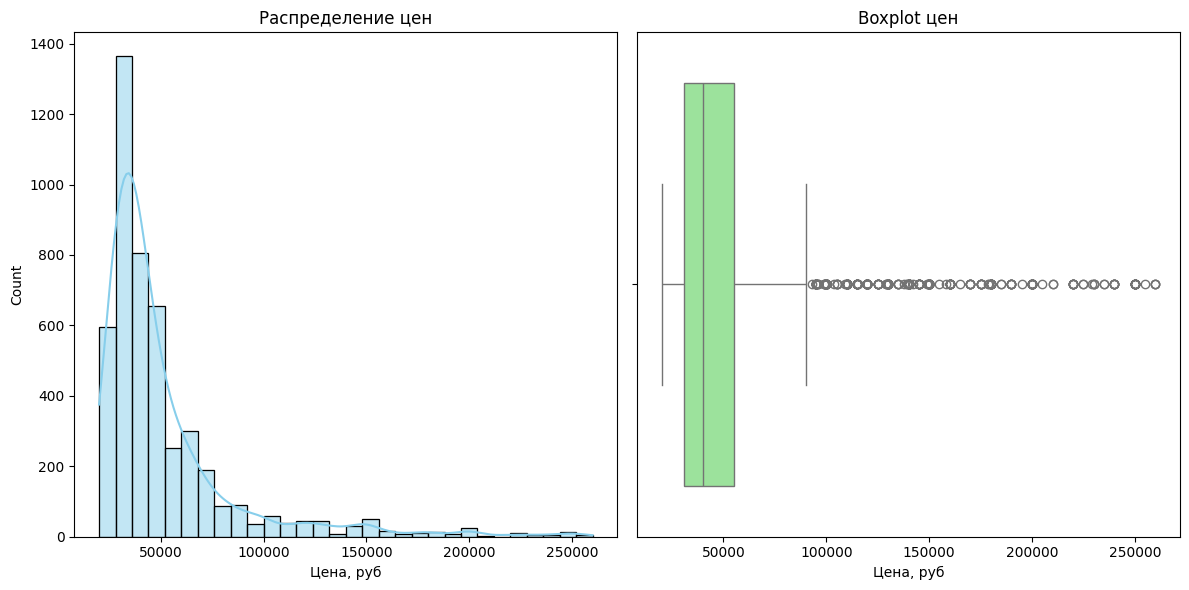

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['price'], bins=30, kde=True, color='skyblue')
plt.title("Распределение цен")
plt.xlabel("Цена, руб")

plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['price'], color='lightgreen')
plt.title("Boxplot цен")
plt.xlabel("Цена, руб")
plt.tight_layout()
plt.show()

Распределение цен имеет правостороннюю асимметрию, то есть большинство цен сосредоточено в нижнем диапазоне (около 50,000 руб), а затем резко уменьшается.
Наблюдается постепенное уменьшение количества по мере увеличения цен, с редкими высокими значениями.

Ящик показывает, что 50% данных лежат в относительно узком диапазоне.

C:\Users\popov\AppData\Local\Temp\ipykernel_16844\2179013965.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rooms', y='price', data=room_price, ax=axes[0, 1], palette='Blues_d')


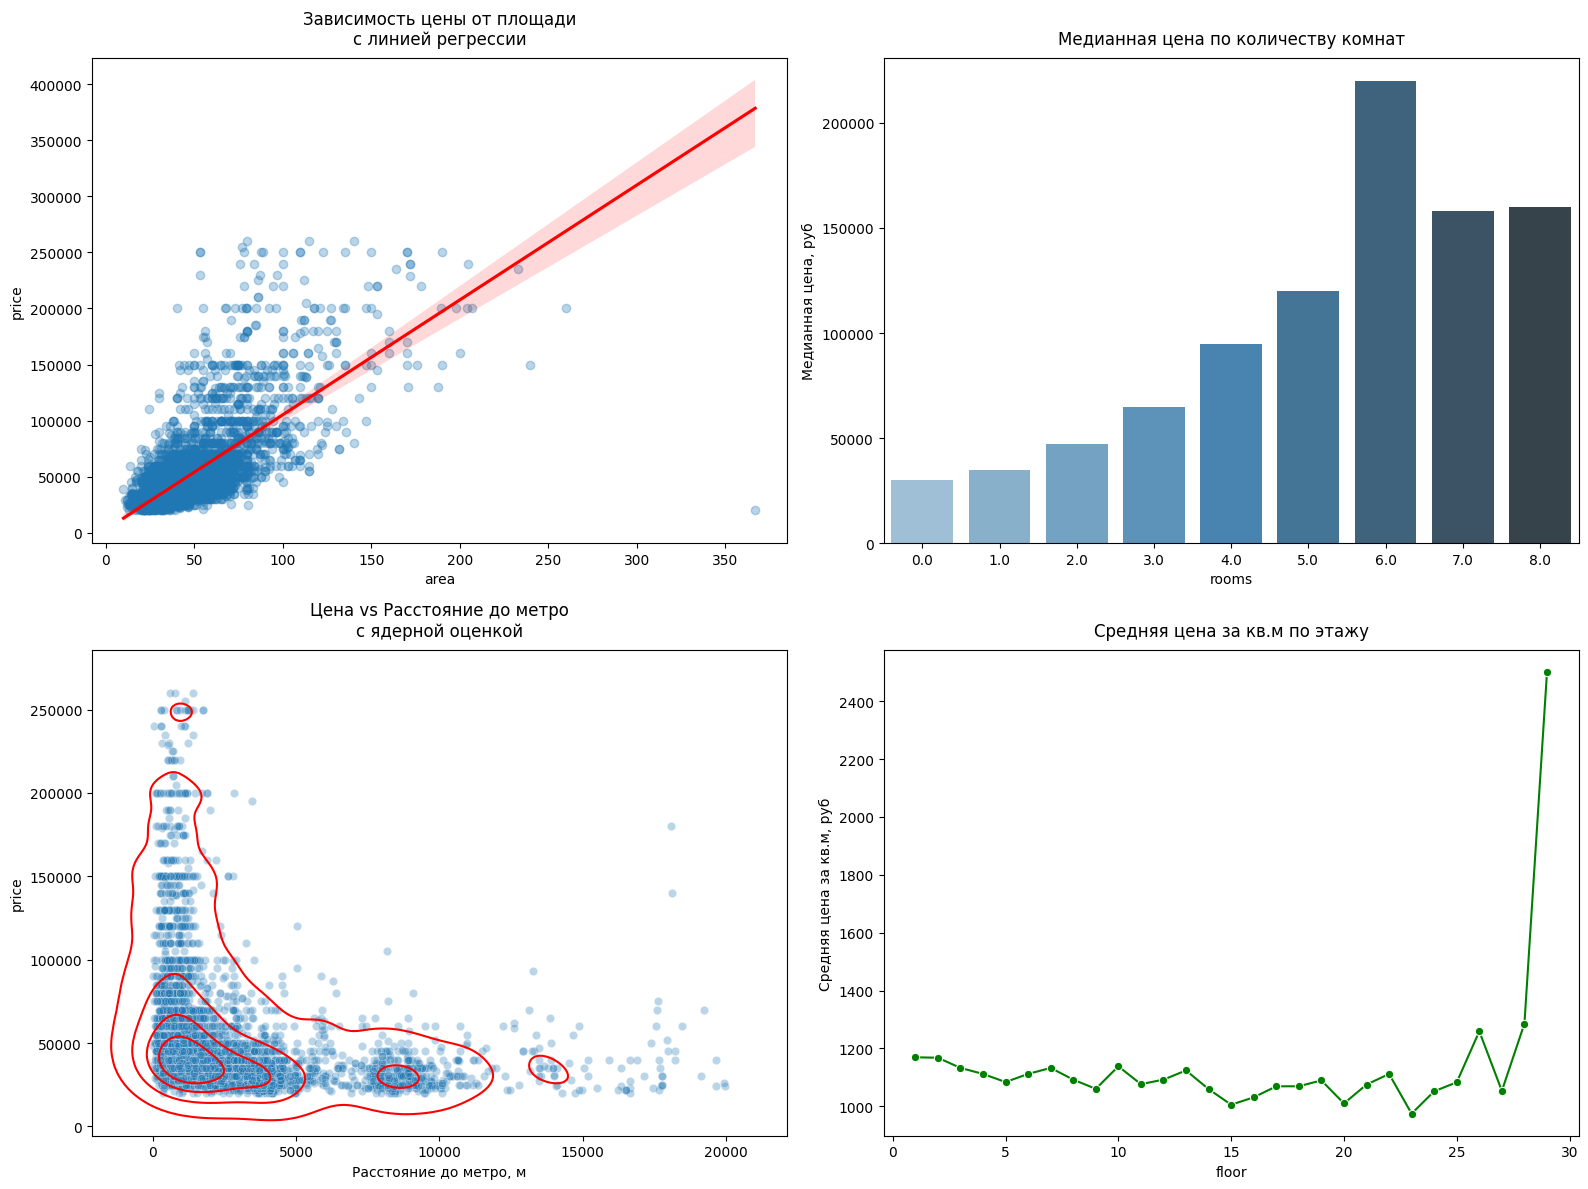

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.regplot(x='area', y='price', data=df_filtered, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, 
            ax=axes[0, 0])
axes[0, 0].set_title("Зависимость цены от площади\nс линией регрессии", pad=10)

room_price = df_filtered.groupby('rooms')['price'].median().reset_index()
sns.barplot(x='rooms', y='price', data=room_price, ax=axes[0, 1], palette='Blues_d')
axes[0, 1].set_title("Медианная цена по количеству комнат", pad=10)
axes[0, 1].set_ylabel("Медианная цена, руб")

sns.scatterplot(x='dist_to_metro', y='price', data=df_filtered, 
                alpha=0.3, ax=axes[1, 0])
sns.kdeplot(x='dist_to_metro', y='price', data=df_filtered, 
            levels=5, color='red', ax=axes[1, 0])
axes[1, 0].set_title("Цена vs Расстояние до метро\nс ядерной оценкой", pad=10)
axes[1, 0].set_xlabel("Расстояние до метро, м")

floor_price = df_filtered.groupby('floor')['price_per_sqm'].mean().reset_index()
sns.lineplot(x='floor', y='price_per_sqm', data=floor_price, 
             marker='o', ax=axes[1, 1], color='green')
axes[1, 1].set_title("Средняя цена за кв.м по этажу", pad=10)
axes[1, 1].set_ylabel("Средняя цена за кв.м, руб")

plt.tight_layout()
plt.show()

Наблюдается положительная корреляция между площадью и ценой: с увеличением площади цена также увеличивается.
Линия регрессии показывает общую тенденцию роста цен с увеличением площади, хотя есть разброс данных, особенно на больших площадях.

Медианная цена увеличивается с ростом количества комнат. 
Особенно заметен рост цен на квартиры с 4 и 6 комнатами.

Наибольшая концентрация более дорогих объектов находится вблизи метро (до 2500 м).
С увеличением расстояния от метро цены, как правило, снижаются.

Видно, что средняя цена за квадратный метр варьируется в зависимости от этажа.
Есть пики на некоторых этажах, что может быть связано с предпочтениями покупателей или особенностями конкретных зданий на этих этажах.

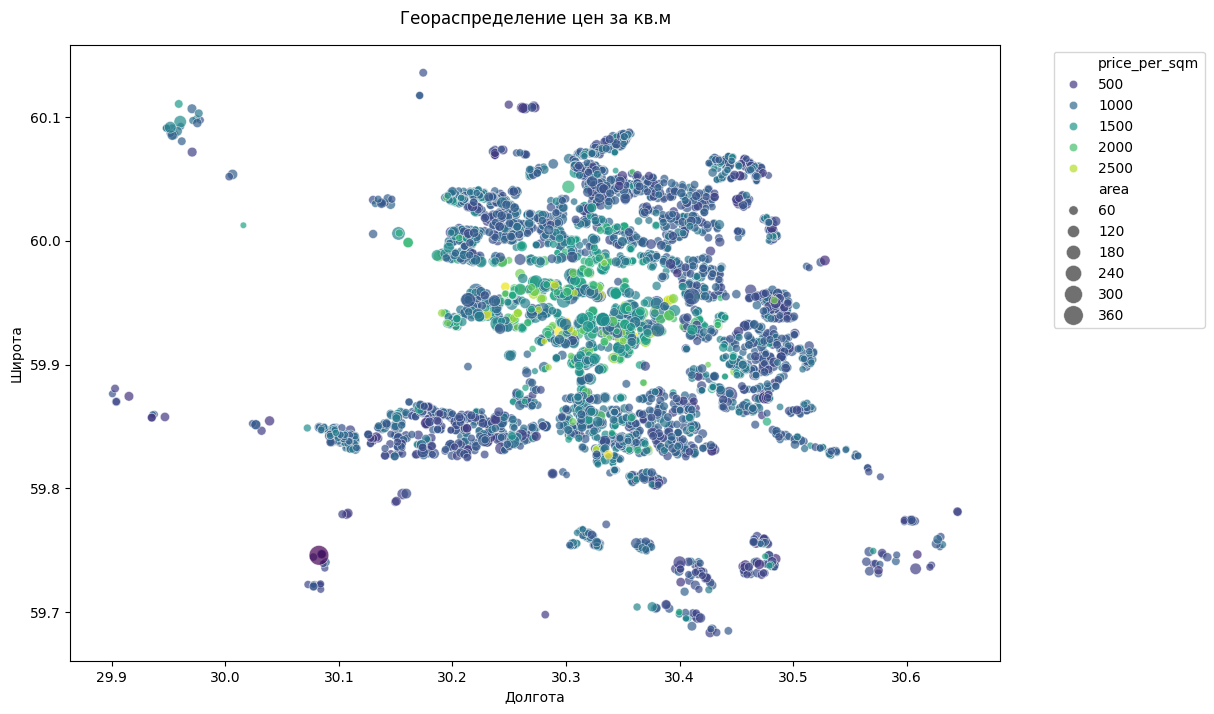

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='longitude', y='latitude', 
    hue='price_per_sqm', 
    size='area',
    sizes=(20, 200),
    palette='viridis',
    alpha=0.7,
    data=df_filtered[df_filtered['price_per_sqm'] <= df_filtered['price_per_sqm'].quantile(0.99)]
)
plt.title("Геораспределение цен за кв.м", pad=15)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Размер точек указывает на площадь объекта. Более крупные точки представляют большие площади.
Видно, что более крупные объекты присутствуют в разнообразных ценовых сегментах.

Основная концентрация объектов находится в центральных районах, где наблюдаются более высокие цены.
В отдалённых районах цены, как правило, ниже, что видно по преобладанию фиолетовых точек.

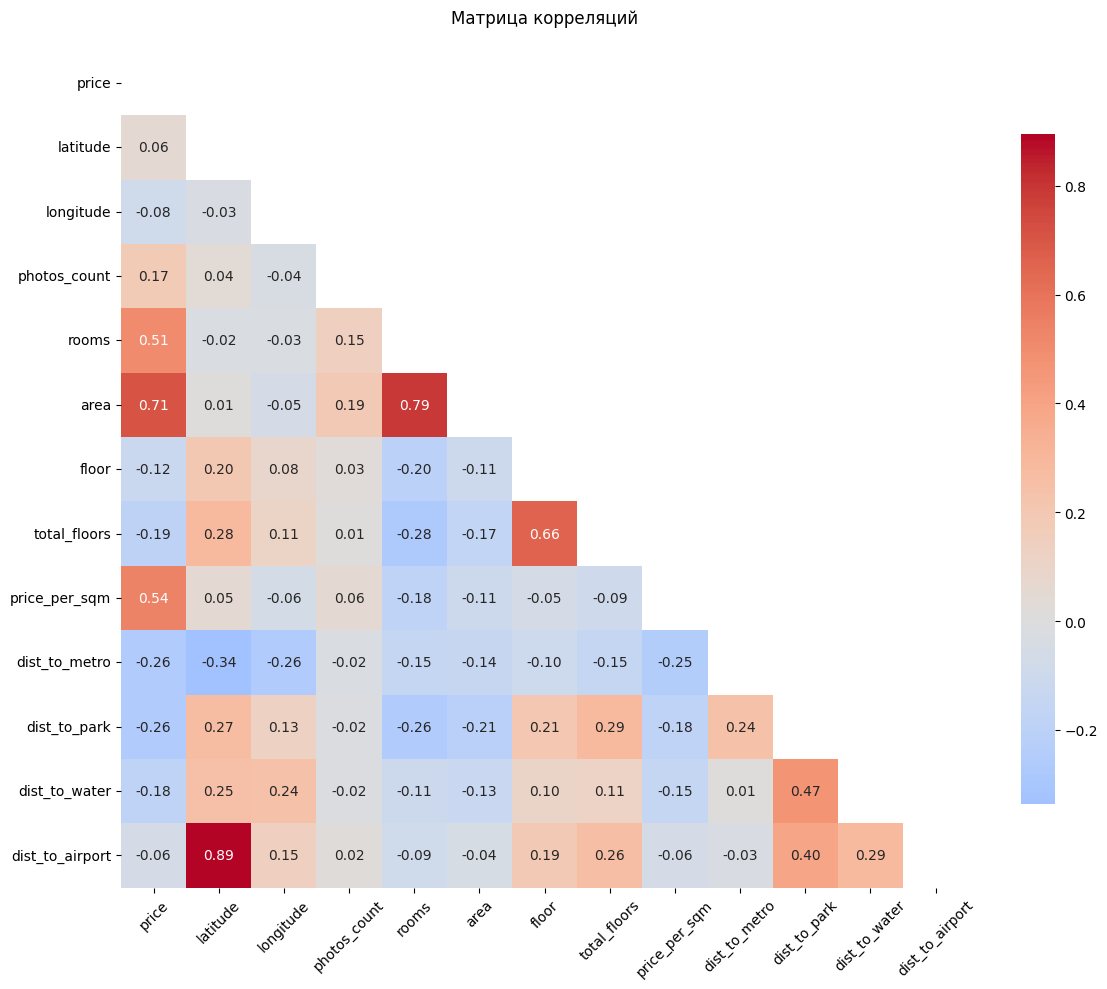

In [22]:
numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = [col for col in numeric_cols if col not in ['id']]

plt.figure(figsize=(12, 10))
corr = df_filtered[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            annot_kws={"size": 10}, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций", pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Цена:**

Сильно коррелирует с площадью (0.73) и количеством комнат (0.52). Это указывает на то, что более крупные и многокомнатные объекты, как правило, дороже.
Умеренная корреляция с ценой за квадратный метр (0.55), что логично, так как цена напрямую зависит от стоимости квадратного метра.

**Площадь:**

Высокая корреляция с количеством комнат (0.80), что ожидаемо, так как больше комнат обычно означает большую площадь.

**Расстояние до аэропорта:**

Высокая отрицательная корреляция с долготой (-0.90), тк учитывался только один аэропорт, который находится на Юге города.

**Расстояние до метро, парка, воды:**

Отрицательная корреляция с ценой, что говорит о том, что объекты, расположенные ближе к этим локациям, обычно дороже.

**Этаж и количество этажей:**

Умеренная положительная корреляция между собой (0.65), что тоже вполне логично (чем больше в здании этажей, тем больше может быть этаж объекта).

_______________________

## Возможные применения в машинном обучении

Полученные данные можно использовать в машинном обучении для:

- **Предсказания цен:** создание моделей, которые определяют стоимость на основе параметров, описаний и изображений.

- **Анализа текстов:** извлечение ключевых характеристик из описаний для улучшения прогнозов и понимания предпочтений клиентов.

- **Обработки изображений:** анализ фотографий с помощью компьютерного зрения или разметки, чтобы оценить состояние или привлекательность объектов.

- **Выявления аномалий:** обнаружение несоответствий между описанием, фотографиями и ценой для проверки достоверности данных.

___________________

## Defenition of Done

✅ Соберите данные из двух разных источников (открытый датасет + веб-скрейпинг или API).


✅ Проведите их агрегацию, создав единый датасет.


✅ Проведите разведывательный анализ данных (EDA).


✅ Постройте базовые визуализации для основных признаков с учетом разметки данных.


✅ Опишите возможные применения этих данных в контексте машинного обучения.